In [1]:
import pandas as pd
import polars as pl
import polars.selectors as cs
from catboost import Pool, CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tempfile
import os
import zipfile
import shap


In [2]:
def read_dataset_export(file_name, src_folder=".",
                        tmp_folder=None,
                        lazy=False,
                        verbose=False):
    json_file = None
    error_reason = ""
    tmp_folder = tmp_folder if tmp_folder else tempfile.gettempdir()

    if file_name.endswith(".json"):
        error_reason = "Error reading JSON file"
        if os.path.exists(file_name):
            json_file = file_name
        elif os.path.exists(os.path.join(src_folder, file_name)):
            json_file = os.path.join(src_folder, file_name)
        if json_file and verbose:
            print(error_reason, json_file)
        if json_file:
            if lazy:
                multi_line_json = pl.scan_ndjson(json_file)
            else:
                multi_line_json = pl.read_ndjson(json_file)

    else:
        zip_file = file_name
        if file_name.endswith(".zip"):
            error_reason = "Error reading ZIP file"
            if os.path.exists(file_name):
                zip_file = file_name
            elif os.path.exists(os.path.join(src_folder, file_name)):
                zip_file = os.path.join(src_folder, file_name)
            if verbose:
                print(error_reason, zip_file)

            if os.path.exists(zip_file):
                error_reason = "Error extracting data.json"
                if verbose:
                    print(error_reason, zip_file)

                json_file = os.path.join(tmp_folder, "data.json")
                if os.path.exists(json_file):
                    os.remove(json_file)

                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    all_zip_entries = zip_ref.namelist()
                    json_file_in_zip = [s for s in all_zip_entries if "data.json" in s]
                    if verbose:
                        print("data.json in zip file:", json_file_in_zip, zip_file)

                    for file in json_file_in_zip:
                        zip_ref.extract(file, tmp_folder)
                        json_file = os.path.join(tmp_folder, file)

                if not os.path.exists(json_file):
                    raise Exception(f"Dataset zipfile {zip_file} does not have \"data.json\"")
                if lazy:
                    multi_line_json = pl.scan_ndjson(json_file, infer_schema_length=100000)
                else:
                    multi_line_json = pl.read_ndjson(json_file, infer_schema_length=100000)
                    os.remove(json_file)

    if json_file is None:
        raise Exception(f"Dataset export not found {error_reason}")
    return multi_line_json

## Read and Pre-process data

In [3]:
df = read_dataset_export( "Web_ClickThrough.zip", lazy=True, verbose=True)
df.describe()

Error reading ZIP file Web_ClickThrough.zip
Error extracting data.json Web_ClickThrough.zip
data.json in zip file: ['data.json'] Web_ClickThrough.zip


statistic,Decision_DecisionTime,IH_Web_Inbound_Impression_pxLastOutcomeTime_DaysSince,Customer_IsInCollections,Context_Treatment,Customer_IsCreditScoreStale,Customer_IsInActiveComplaint,Customer_IsIncarcerated,Customer_BirthDate,IH_Web_Inbound_Clicked_pyHistoricalOutcomeCount,Customer_IsInDisasterArea,Context_Direction,negativeSampling,Customer_MKTCLVValue,Customer_PrimaryMobilePhone,Customer_PrimaryCountry,Param_DaysinCurrentStage,IH_Web_Inbound_Impression_pxLastGroupID,pyModelEvidence,Customer_IsActiveMilitaryService,pyModelPerformance,Customer_HasBrokenPromise,Customer_DebtToIncomeRatio,Customer_AnnualIncome,pyModelPositives,Customer_IsCustomerActive,rulesetVersion,pyPropensity,IH_Retail_Inbound_Impression_pxLastGroupID,Customer_NumInvestmentAccount,Customer_LinkedIn,Param_JourneyStage,Customer_Prefix,Customer_CLV,Decision_Outcome,Param_LastJourneyStage,Customer_OrganizationName,…,Decision_SubjectID,IH_Retail_Inbound_Impression_pxLastOutcomeTime_DaysSince,Customer_ResidentialStatus,Customer_IsFinanciallyVulnerable,Customer_PrimaryState,Customer_IsB2C,Param_Journey,Context_Name,Customer_IsInArrears,Customer_PrimaryCountryCode,Customer_TotalAssets,positiveSampling,IH_Web_Inbound_Clicked_pxLastGroupID,IH_Web_Inbound_Clicked_pxLastOutcomeTime_DaysSince,Customer_PrimaryCity,Customer_TotalLiabilities,Customer_IsProspect,Customer_NumLoanAccount,Customer_PrimaryPostalCode,IH_Retail_Inbound_Impression_pyHistoricalOutcomeCount,Context_Channel,Context_Group,Decision_InteractionID,Customer_NetWealth,Customer_OwnershipStatus,Customer_HasCriticalIllness,Customer_IsStudent,Customer_OrganizationID,Decision_OutcomeTime,Customer_NumCreditCardAccount,IH_Web_Inbound_Impression_pyHistoricalOutcomeCount,dataCenter,Customer_CreditScore,rulesetName,Customer_IsInPrecollections,Param_PriorStageInJourney,Customer_OwnedAccountTypes
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""count""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""",32091.0,"""162""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""",…,"""32091""","""162""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""162""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""32091""","""9513"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""31929""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",…,"""0""","""31929""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""31929""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""22578"""
"""mean""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.599699,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,nu

In [4]:
columns = df.collect_schema().names()
columns.sort()
columns

['Context_Channel',
 'Context_Direction',
 'Context_Group',
 'Context_Issue',
 'Context_Name',
 'Context_Treatment',
 'Customer_AnnualIncome',
 'Customer_BirthDate',
 'Customer_CLV',
 'Customer_CreditScore',
 'Customer_DebtToIncomeRatio',
 'Customer_HasBrokenPromise',
 'Customer_HasCriticalIllness',
 'Customer_IsActiveMilitaryService',
 'Customer_IsB2C',
 'Customer_IsBankruptcy',
 'Customer_IsCreditScoreStale',
 'Customer_IsCustomerActive',
 'Customer_IsFinanciallyVulnerable',
 'Customer_IsInActiveComplaint',
 'Customer_IsInArrears',
 'Customer_IsInCollections',
 'Customer_IsInDisasterArea',
 'Customer_IsInPrecollections',
 'Customer_IsIncarcerated',
 'Customer_IsProspect',
 'Customer_IsStudent',
 'Customer_LinkedIn',
 'Customer_MKTCLVValue',
 'Customer_NetWealth',
 'Customer_NumCreditCardAccount',
 'Customer_NumDepositAccount',
 'Customer_NumInvestmentAccount',
 'Customer_NumLoanAccount',
 'Customer_OrganizationID',
 'Customer_OrganizationName',
 'Customer_OwnedAccountTypes',
 'Custom

In [5]:
df = df.unique(subset=['Decision_InteractionID', 'Context_Treatment'], keep='last')

In [6]:
df = df.with_columns(
    pl.when(pl.col(pl.String).str.len_chars() == 0)
    .then(None)
    .otherwise(pl.col(pl.String))
    .name.keep()
    ).with_columns(
        cs.ends_with("_DaysSince", 
                     "_pyHistoricalOutcomeCount",
                     "DaysinCurrentStage")
                     .cast(pl.Float64).fill_null(0),
        pl.col(
            [
                "Customer_AnnualIncome",
                "Customer_CreditScore",
                "Customer_DebtToIncomeRatio",
                "Customer_NetWealth",
                "Customer_RelationshipLengthDays",
                "Customer_TotalAssets",
                "Customer_TotalLiabilities",
                "Customer_BirthDate"
            ]
            )
        .cast(pl.Float64)
        .fill_null(0),
        cs.starts_with("Customer_Num").cast(pl.Float64).fill_null(0),
        cs.starts_with("Context_").cast(pl.String),
        cs.starts_with("Customer_Is").replace_strict({"false":False, "true":True, "null":False, "False":False, "True":True}),
        cs.starts_with("Customer_Has").replace_strict({"false":False, "true":True, "null":False, "False":False, "True":True})
    ).with_columns(
        cs.starts_with("Customer_Is").fill_null(False).cast(pl.Boolean),
        cs.starts_with("Customer_Has").fill_null(False).cast(pl.Boolean)
    ).with_columns(
        pl.col(
            [
                "Customer_AnnualIncome",
                "Customer_CreditScore",
                "Customer_DebtToIncomeRatio",
                "Customer_NetWealth",
                "Customer_RelationshipLengthDays",
                "Customer_TotalAssets",
                "Customer_TotalLiabilities"
            ]
        ).cast(pl.Float64).fill_null(0),
    )

In [7]:
df = df.drop(["rulesetVersion", "id", "dataCenter", "negativeSampling", "positiveSampling", "rulesetName",
                "Decision_SubjectID", "Decision_OutcomeTime", "Decision_Rank", "Decision_InteractionID",
                "Decision_DecisionTime", "Decision_OutcomeWeight", "pyModelEvidence", "pyModelPerformance", 
                "pyModelPositives", "pyPropensity", "rulesetVersion"])


In [8]:
cat_features = list()
schema = df.collect_schema()

for cname in schema.names():
    ctype = schema[cname]
    if(not(cname.startswith("Decision_")) and pl.String.is_(ctype)):
        df = df.with_columns(pl.col(cname).fill_null('N/A'))
        cat_features.append(cname)
print(cat_features)

['Context_Treatment', 'Context_Direction', 'Customer_MKTCLVValue', 'Customer_PrimaryMobilePhone', 'Customer_PrimaryCountry', 'IH_Web_Inbound_Impression_pxLastGroupID', 'IH_Retail_Inbound_Impression_pxLastGroupID', 'Customer_LinkedIn', 'Param_JourneyStage', 'Customer_Prefix', 'Customer_CLV', 'Param_LastJourneyStage', 'Customer_OrganizationName', 'Context_Issue', 'Customer_ResidentialStatus', 'Customer_PrimaryState', 'Param_Journey', 'Context_Name', 'Customer_PrimaryCountryCode', 'IH_Web_Inbound_Clicked_pxLastGroupID', 'Customer_PrimaryCity', 'Customer_PrimaryPostalCode', 'Context_Channel', 'Context_Group', 'Customer_OwnershipStatus', 'Customer_OrganizationID', 'Param_PriorStageInJourney', 'Customer_OwnedAccountTypes']


In [9]:
text_processing_options = {
    "tokenizers": [{
        "tokenizer_id": "comma",
        "delimiter": ",",
        "lowercasing": "true"
    }],

    "dictionaries": [{
        "dictionary_id": "Word",
        "gram_order": "1"
    }],

    "feature_processing": {
        "default": [{
            "dictionaries_names": ["Word"],
            "feature_calcers": ["BoW"],
            "tokenizers_names": ["comma"]
        }]
    }
}
text_features = ['Customer_OwnedAccountTypes']


In [10]:
cat_features = list(set(cat_features) - set(text_features))

In [11]:
df = df.collect()
df.head()

IH_Web_Inbound_Impression_pxLastOutcomeTime_DaysSince,Customer_IsInCollections,Context_Treatment,Customer_IsCreditScoreStale,Customer_IsInActiveComplaint,Customer_IsIncarcerated,Customer_BirthDate,IH_Web_Inbound_Clicked_pyHistoricalOutcomeCount,Customer_IsInDisasterArea,Context_Direction,Customer_MKTCLVValue,Customer_PrimaryMobilePhone,Customer_PrimaryCountry,Param_DaysinCurrentStage,IH_Web_Inbound_Impression_pxLastGroupID,Customer_IsActiveMilitaryService,Customer_HasBrokenPromise,Customer_DebtToIncomeRatio,Customer_AnnualIncome,Customer_IsCustomerActive,IH_Retail_Inbound_Impression_pxLastGroupID,Customer_NumInvestmentAccount,Customer_LinkedIn,Param_JourneyStage,Customer_Prefix,Customer_CLV,Decision_Outcome,Param_LastJourneyStage,Customer_OrganizationName,Customer_RelationshipLengthDays,Context_Issue,Customer_NumDepositAccount,Customer_IsBankruptcy,IH_Retail_Inbound_Impression_pxLastOutcomeTime_DaysSince,Customer_ResidentialStatus,Customer_IsFinanciallyVulnerable,Customer_PrimaryState,Customer_IsB2C,Param_Journey,Context_Name,Customer_IsInArrears,Customer_PrimaryCountryCode,Customer_TotalAssets,IH_Web_Inbound_Clicked_pxLastGroupID,IH_Web_Inbound_Clicked_pxLastOutcomeTime_DaysSince,Customer_PrimaryCity,Customer_TotalLiabilities,Customer_IsProspect,Customer_NumLoanAccount,Customer_PrimaryPostalCode,IH_Retail_Inbound_Impression_pyHistoricalOutcomeCount,Context_Channel,Context_Group,Customer_NetWealth,Customer_OwnershipStatus,Customer_HasCriticalIllness,Customer_IsStudent,Customer_OrganizationID,Customer_NumCreditCardAccount,IH_Web_Inbound_Impression_pyHistoricalOutcomeCount,Customer_CreditScore,Customer_IsInPrecollections,Param_PriorStageInJourney,Customer_OwnedAccountTypes
f64,bool,str,bool,bool,bool,f64,f64,bool,str,str,str,str,f64,str,bool,bool,f64,f64,bool,str,f64,str,str,str,str,str,str,str,f64,str,f64,bool,f64,str,bool,str,bool,str,str,bool,str,f64,str,f64,str,f64,bool,f64,str,f64,str,str,f64,str,bool,bool,str,f64,f64,f64,bool,str,str
0.146562,false,"""Hero Web""",false,false,false,0.0,24.0,false,"""Inbound""","""N/A""","""N/A""","""N/A""",0.0,"""Creditcards""",false,false,49.0,0.0,false,"""N/A""",0.0,"""N/A""","""N/A""","""N/A""","""Loyal""","""Clicked""","""N/A""","""N/A""",1536.0,"""Grow""",1.0,false,0.0,"""N/A""",false,"""N/A""",false,"""N/A""","""VisaClassic""",false,"""N/A""",0.0,"""Creditcards""",0.002222,"""N/A""",0.0,false,2.0,"""N/A""",0.0,"""Web""","""Creditcards""",0.0,"""N/A""",false,true,"""N/A""",1.0,26.0,5.0,false,"""N/A""","""N/A"""
0.003468,false,"""Hero Web""",false,false,false,0.0,25.0,false,"""Inbound""","""N/A""","""N/A""","""N/A""",0.0,"""Creditcards""",false,false,7.0,0.0,false,"""N/A""",1.0,"""N/A""","""N/A""","""N/A""","""High""","""Clicked""","""N/A""","""N/A""",2619.0,"""Grow""",2.0,false,0.0,"""N/A""",false,"""N/A""",false,"""N/A""","""VisaClassic""",false,"""N/A""",0.0,"""Creditcards""",0.002354,"""N/A""",0.0,false,0.0,"""N/A""",0.0,"""Web""","""Creditcards""",0.0,"""N/A""",false,false,"""N/A""",4.0,24.0,5.0,false,"""N/A""","""N/A"""
0.001437,false,"""Hero Web""",false,false,false,0.0,27.0,false,"""Inbound""","""N/A""","""N/A""","""N/A""",0.0,"""Creditcards""",false,false,17.0,0.0,false,"""N/A""",0.0,"""N/A""","""N/A""","""N/A""","""High""","""Clicked""","""N/A""","""N/A""",2371.0,"""Grow""",1.0,false,0.0,"""N/A""",false,"""N/A""",false,"""N/A""","""VisaClassic""",false,"""N/A""",0.0,"""Creditcards""",0.004371,"""N/A""",0.0,false,1.0,"""N/A""",0.0,"""Web""","""Creditcards""",0.0,"""N/A""",false,false,"""N/A""",2.0,41.0,7.0,false,"""N/A""","""N/A"""
0.000139,false,"""Hero Web""",false,false,false,0.0,13.0,false,"""Inbound""","""N/A""","""N/A""","""N/A""",0.0,"""Creditcards""",false,false,14.0,0.0,false,"""N/A""",0.0,"""N/A""","""N/A""","""N/A""","""Loyal""","""Clicked""","""N/A""","""N/A""",1263.0,"""Grow""",0.0,false,0.0,"""N/A""",false,"""N/A""",false,"""N/A""","""VisaClassic""",false,"""N/A""",0.0,"""Creditcards""",0.000604,"""N/A""",0.0,false,0.0,"""N/A""",0.0,"""Web""","""Creditcards""",0.0

## Train Model

In [12]:
dset = df.to_pandas()
y = dset['Decision_Outcome']
X = dset.drop(['Decision_Outcome'], axis=1)
seed = 127
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=test_size, random_state=seed)

In [13]:

params = {'loss_function': 'Logloss',  # objective function
          'eval_metric': 'AUC',  # metric
          'verbose': 50,  # output to stdout info about training process every 50 iterations
          'random_seed': seed,
          'cat_features': cat_features,
          'text_features': text_features,
          'text_processing': text_processing_options,
          'one_hot_max_size': 255,
          'class_names': ['NoResponse', 'Clicked'],
          'iterations': 100,
          'learning_rate': 0.5,
          'depth': 8
          }


In [14]:
%%time
cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X=X_train, y=y_train,  # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_val, y_val),  # data to validate on
          # True if we don't want to save trees created after iteration with the best validation score
          use_best_model=True,
          # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
          plot=True
          )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8757747	best: 0.8757747 (0)	total: 60.7ms	remaining: 6.01s
50:	test: 0.8668055	best: 0.8802459 (3)	total: 390ms	remaining: 375ms
99:	test: 0.8610941	best: 0.8802459 (3)	total: 699ms	remaining: 0us

bestTest = 0.8802458595
bestIteration = 3

Shrink model to first 4 iterations.
CPU times: user 2.83 s, sys: 670 ms, total: 3.5 s
Wall time: 820 ms


## Review Model Parameters

In [15]:
pool = Pool(X_test, y_test, cat_features=cat_features, text_features=text_features)
#pool = Pool(X_test, y_test, cat_features=cat_features)

In [16]:
cbc_1.get_all_params()


{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 255,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 1,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderTyp

In [17]:
cbc_1.plot_tree(
    tree_idx=0,
    pool=pool
)


In [18]:
feature_importance = cbc_1.get_feature_importance(data=pool,
                                                  prettified=True,
                                                  verbose=True, type="PredictionValuesChange")
feature_importance


Used dataset leave statistics for fstr calculation


,Feature Id,Importances
0,Customer_CLV,38.474684
1,Customer_DebtToIncomeRatio,18.284089
2,Customer_CreditScore,17.182383
3,Customer_RelationshipLengthDays,14.840946
4,IH_Web_Inbound_Clicked_pxLastOutcomeTime_DaysS...,3.224802
...,...,...
58,Customer_IsStudent,0.000000
59,Customer_OrganizationID,0.000000
60,IH_Web_Inbound_Impression_pyHistoricalOutcomeC...,0.000000
61,Customer_IsInPrecollections,0.000000


In [19]:
feature_importance = cbc_1.get_feature_importance(data=pool,
                                                  prettified=True,
                                                  verbose=True, type="LossFunctionChange")
feature_importance


Used Logloss metric for fstr calculation
Selected 3210 documents from 3210 for LossFunctionChange calculation.
Used Logloss metric for fstr calculation
Started LossFunctionChange calculation
3210/3210 Process documents	passed time: 3.69ms	remaining time: 0us


,Feature Id,Importances
0,Customer_OwnedAccountTypes,0.116788
1,Customer_CreditScore,0.046167
2,Customer_DebtToIncomeRatio,0.042863
3,Customer_RelationshipLengthDays,0.032864
4,Customer_CLV,0.031211
...,...,...
58,Customer_OrganizationID,0.000000
59,IH_Web_Inbound_Impression_pyHistoricalOutcomeC...,0.000000
60,Customer_IsInPrecollections,0.000000
61,Param_PriorStageInJourney,0.000000


In [20]:
# make the prediction using the resulting model
preds = cbc_1.predict(pool)
preds_proba = cbc_1.predict_proba(pool)
print(preds_proba[:5])
print(cbc_1.predict(pool, 'RawFormulaVal')[:5])


[[0.99012503 0.00987497]
 [0.63232841 0.36767159]
 [0.2427312  0.7572688 ]
 [0.48538298 0.51461702]
 [0.23463906 0.76536094]]
[-4.60782788 -0.54221876  1.1377636   0.05848474  1.18229912]


In [21]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, preds, labels=params.get('class_names')))
print(metrics.classification_report(
    y_test, preds, labels=params.get('class_names')))


[[1019  268]
 [ 379 1544]]
              precision    recall  f1-score   support

  NoResponse       0.73      0.79      0.76      1287
     Clicked       0.85      0.80      0.83      1923

    accuracy                           0.80      3210
   macro avg       0.79      0.80      0.79      3210
weighted avg       0.80      0.80      0.80      3210



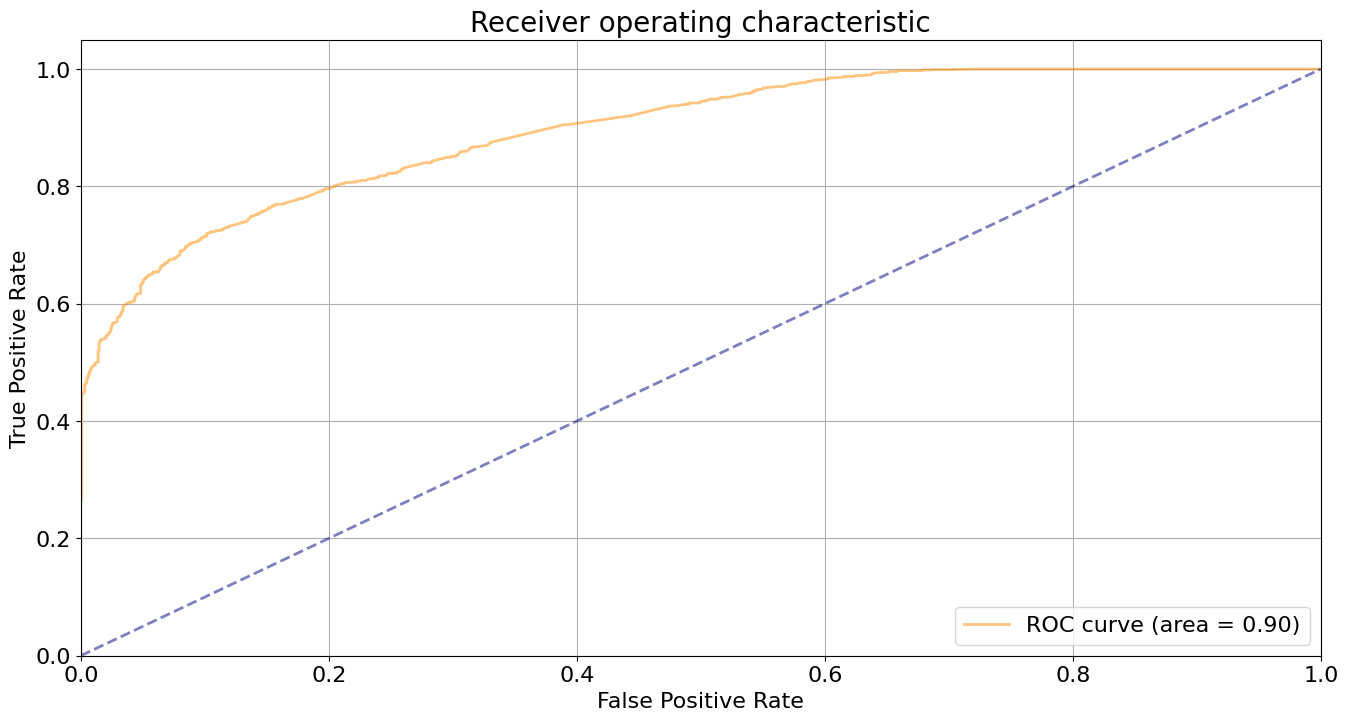

In [22]:
from catboost.utils import get_roc_curve
from sklearn.metrics import auc

curve = get_roc_curve(cbc_1, pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [23]:
print('error:', 1-np.mean(preds == np.ravel(y_test)))


error: 0.2015576323987539


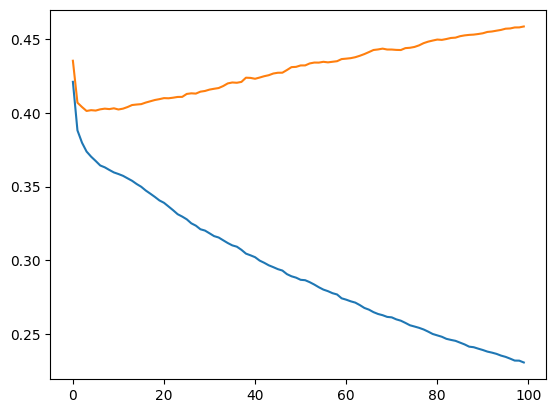

In [24]:
rmse_learn = pd.read_csv(
    'catboost_info/learn_error.tsv', header=0, delimiter='\t')
rmse_test = pd.read_csv('catboost_info/test_error.tsv',
                        header=0, delimiter='\t')
plt.plot(rmse_learn['Logloss'], label="Learn Error")
plt.plot(rmse_test['Logloss'], label="Test Error")


## Model Analysis

In [25]:
shap.initjs()

In [26]:
shap_values = cbc_1.get_feature_importance(pool, type="ShapValues")

In [27]:
expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]


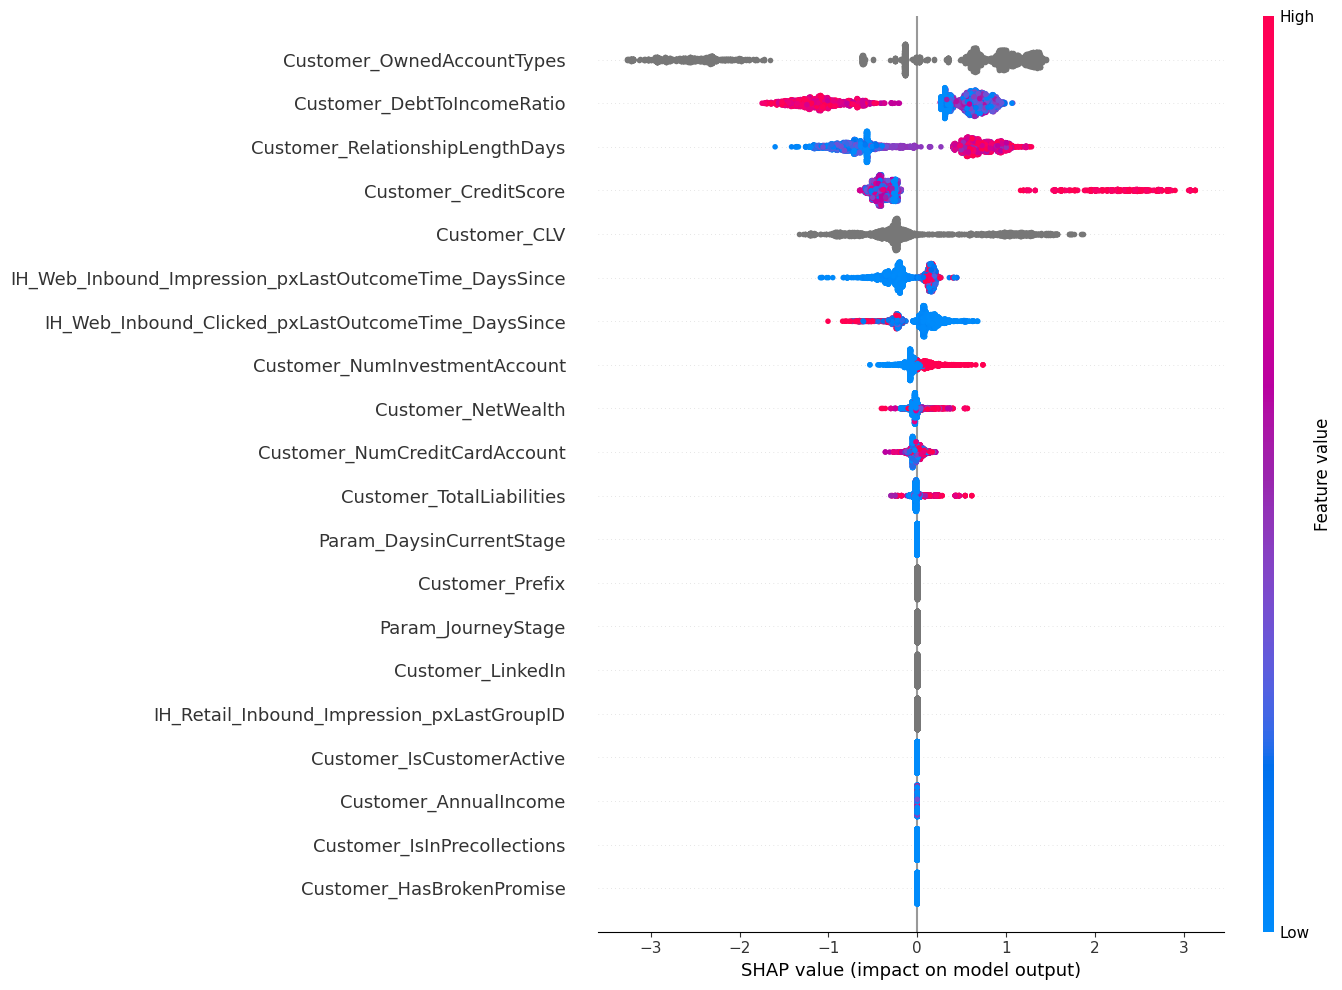

In [28]:
shap.summary_plot(shap_values, X_test, max_display=20, plot_size=[14,10])


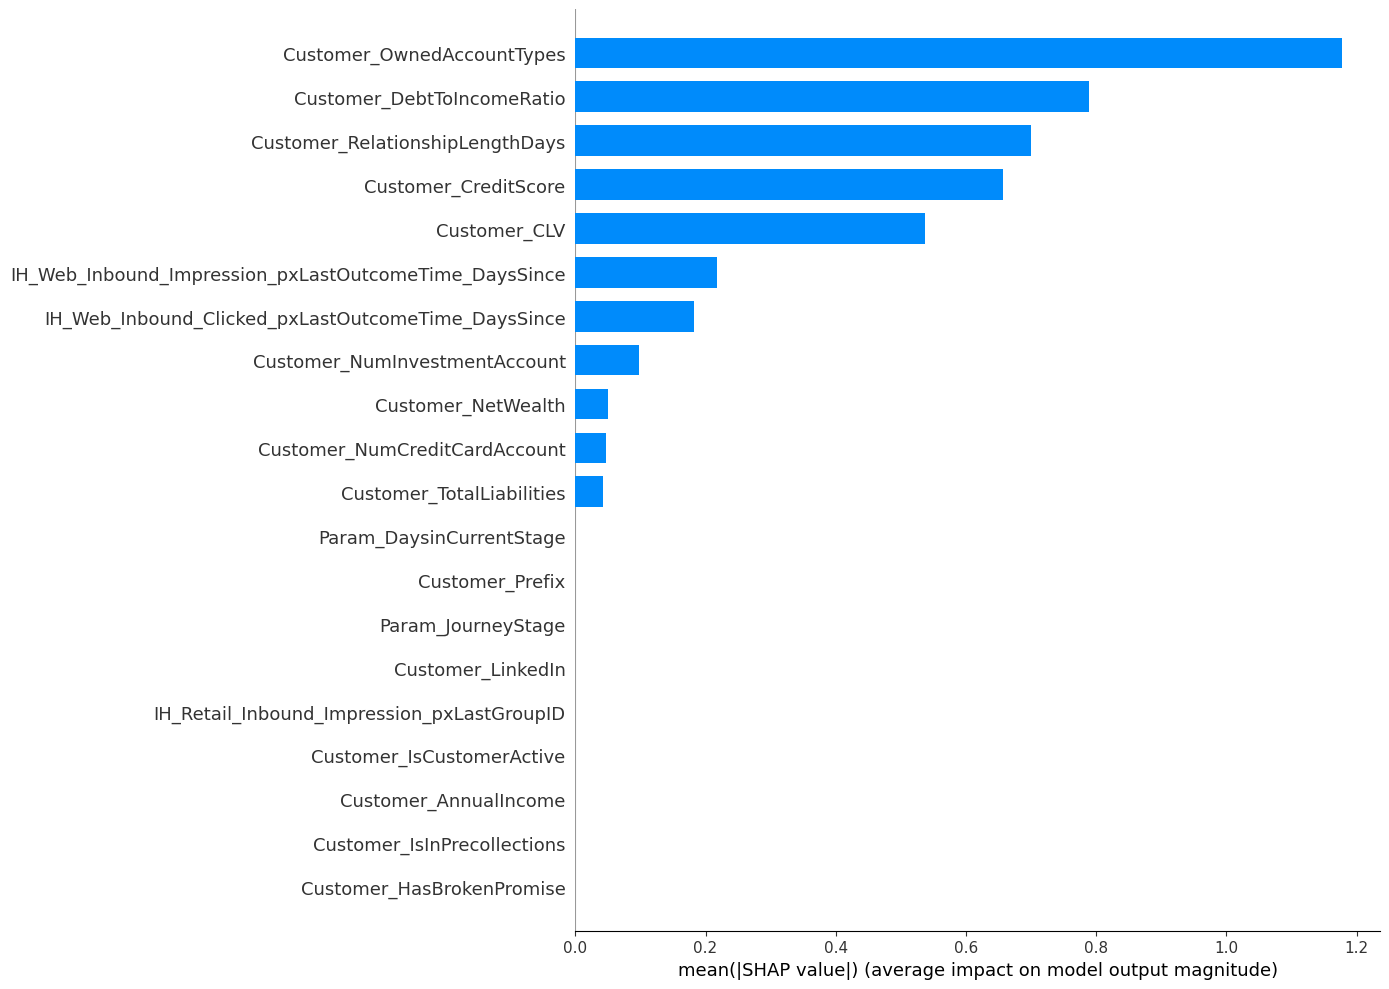

In [29]:
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=[14,10])

## Prediction Explanations

In [30]:

shap.plots.force(expected_value, shap_values[50], feature_names=X_test.columns)


## Individual Feature Analysis

In [31]:
feature = 'Customer_DebtToIncomeRatio'
res = cbc_1.calc_feature_statistics(X_test, y_test, feature, plot=True)

### Analyse Model Without Text Features

In [32]:
dset = df.to_pandas()
y = dset['Decision_Outcome']
X = dset.drop(['Decision_Outcome'] + text_features, axis=1)
seed = 127
test_size = 0.2
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X, y, test_size=0.1, random_state=seed)
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train2, y_train2, test_size=test_size, random_state=seed)

In [33]:
params = {'loss_function': 'Logloss',  # objective function
          'eval_metric': 'AUC',  # metric
          'verbose': 50,  # output to stdout info about training process every 50 iterations
          'random_seed': seed,
          'cat_features': cat_features,
          'class_names': ['NoResponse', 'Clicked'],
          'iterations': 100,
          'learning_rate': 0.5,
          'depth': 8
          }

In [34]:
%%time
cbc_2 = CatBoostClassifier(**params)
cbc_2.fit(X=X_train2, y=y_train2,  # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_val2, y_val2),  # data to validate on
          # True if we don't want to save trees created after iteration with the best validation score
          use_best_model=True,
          # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
          plot=True
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8069774	best: 0.8069774 (0)	total: 12.1ms	remaining: 1.19s
50:	test: 0.8709794	best: 0.8787351 (8)	total: 594ms	remaining: 571ms
99:	test: 0.8644638	best: 0.8787351 (8)	total: 1.19s	remaining: 0us

bestTest = 0.8787350769
bestIteration = 8

Shrink model to first 9 iterations.
CPU times: user 4.82 s, sys: 994 ms, total: 5.82 s
Wall time: 1.29 s


In [35]:
def print_score_diff(first_model, second_model):
    first_accuracy = first_model.best_score_['validation']['AUC']
    second_accuracy = second_model.best_score_['validation']['AUC']

    gap = (second_accuracy - first_accuracy) / first_accuracy * 100

    print('{} vs {} ({:+.2f}%)'.format(first_accuracy, second_accuracy, gap))
print('Model AUC difference - without text features vs with text features.')
print_score_diff(cbc_2, cbc_1)

Model AUC difference - without text features vs with text features.
0.878735076918468 vs 0.8802458594846138 (+0.17%)


In [36]:
explainer = shap.TreeExplainer(cbc_2)
shap_values_exp = explainer(X_test2)

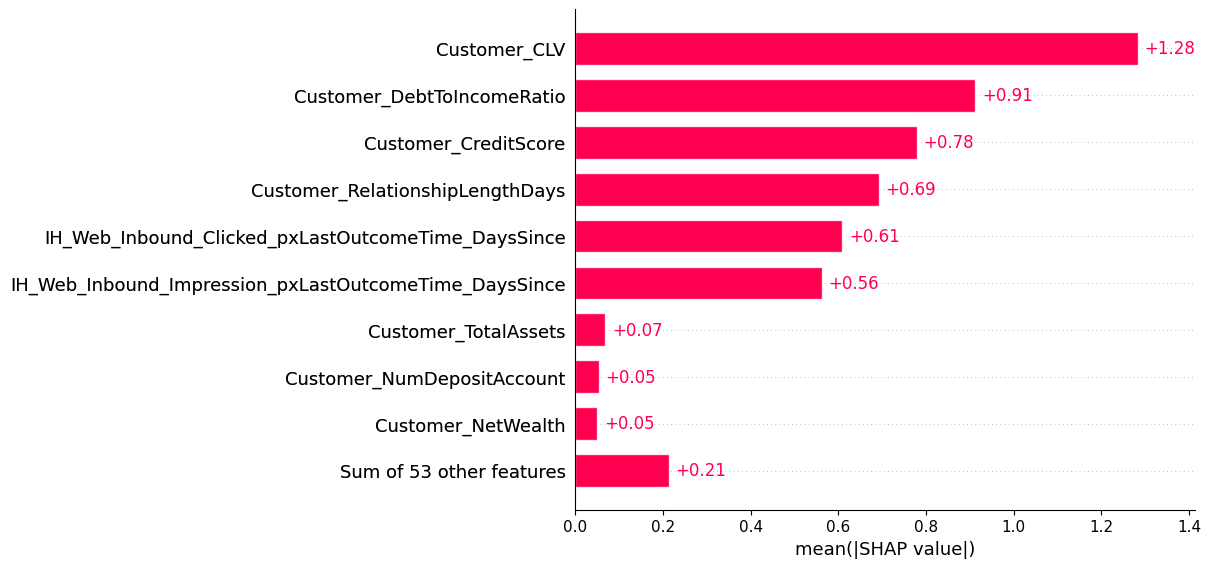

In [37]:
shap.plots.bar(shap_values_exp)

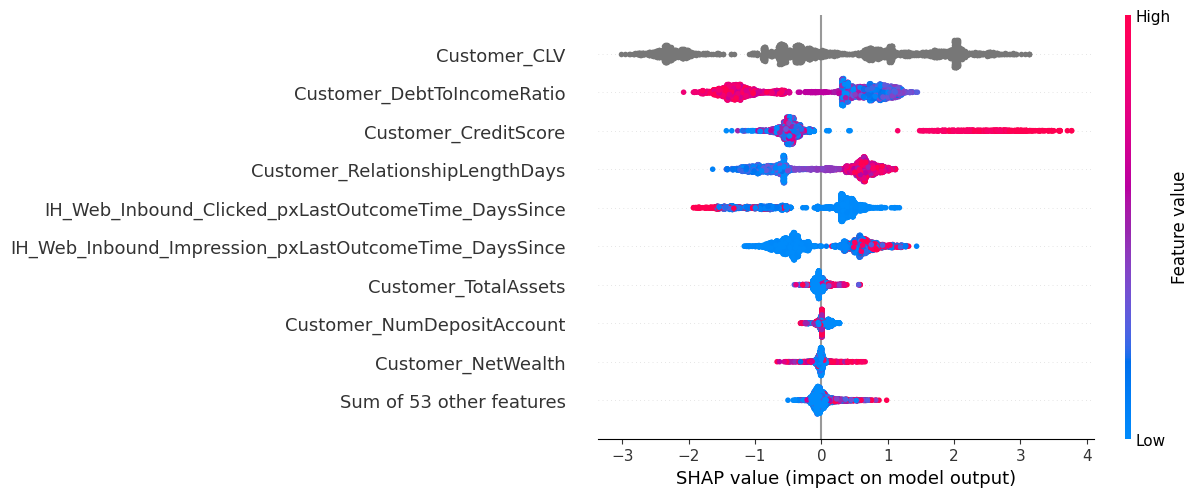

In [38]:
shap.plots.beeswarm(shap_values_exp)

In [39]:
shap.plots.force(explainer(X_test2.sample(n=500, random_state=seed)))

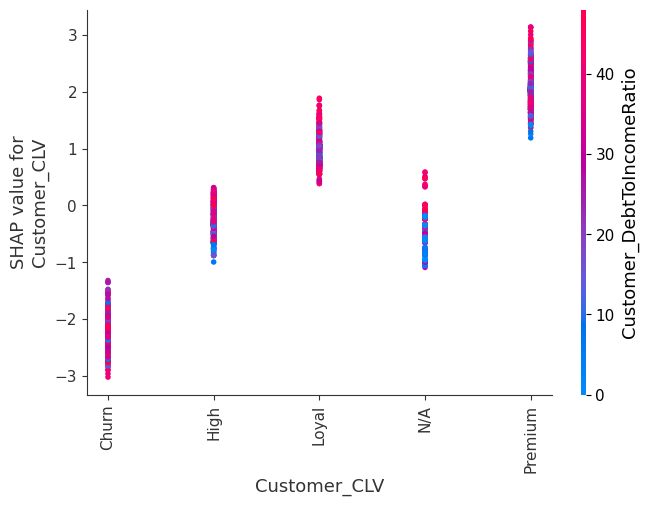

In [40]:
shap.dependence_plot("Customer_CLV", shap_values_exp.values, X_test2, interaction_index="Customer_DebtToIncomeRatio")

### Individual Predition Explanation

In [41]:
shap.plots.force(shap_values_exp[8])

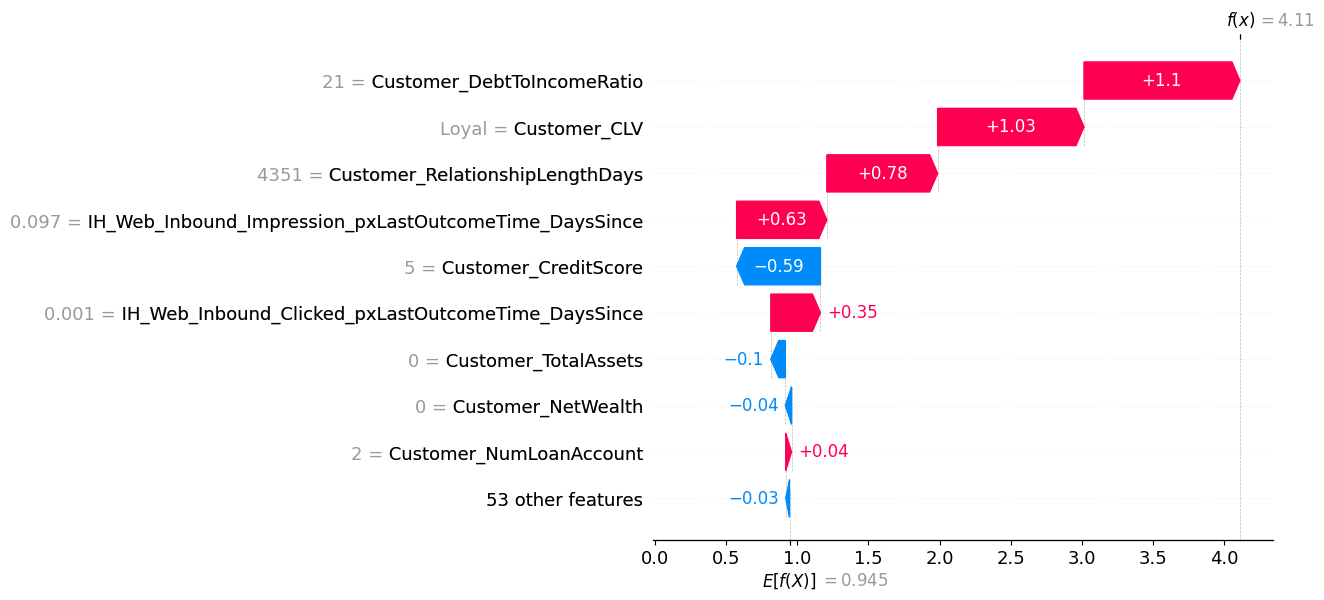

In [42]:
shap.plots.waterfall(shap_values_exp[8])

In [43]:
preds_proba = cbc_2.predict_proba(X_test2.iloc[8])
print(preds_proba)

[0.01614632 0.98385368]


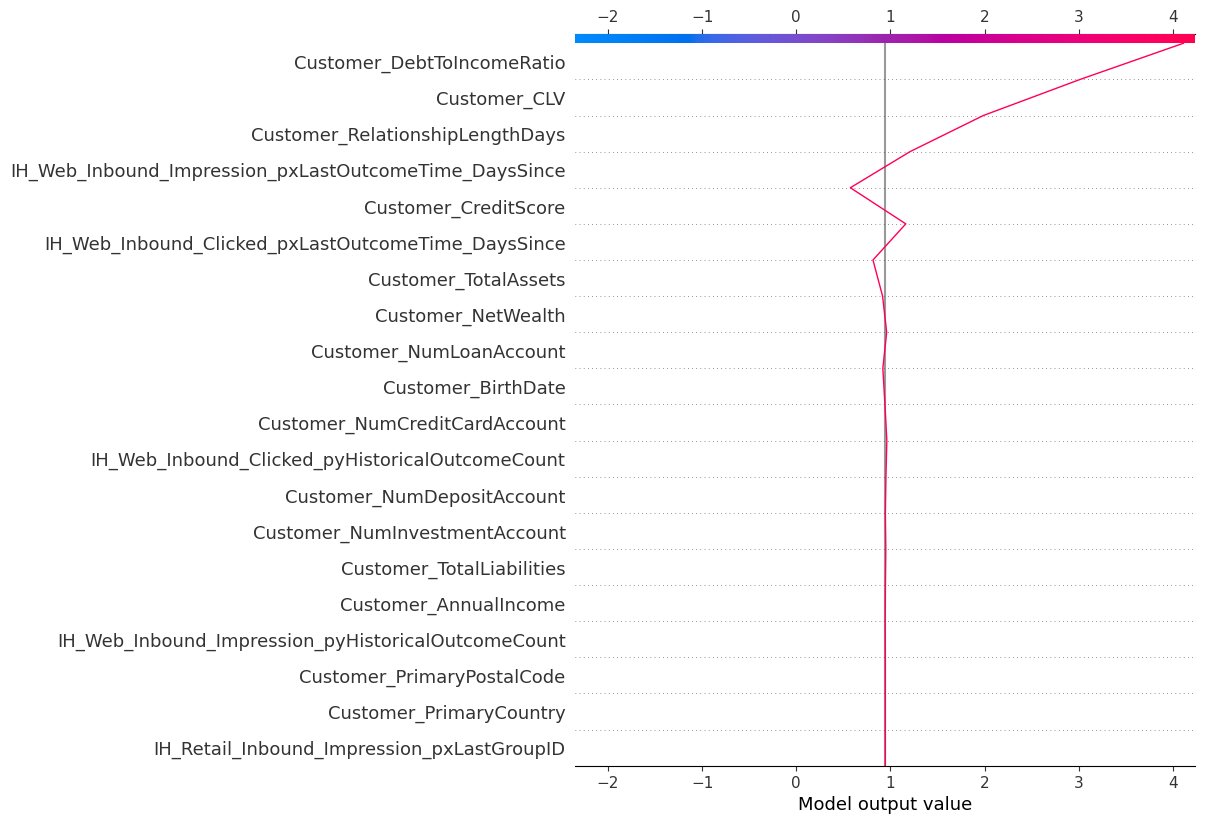

In [44]:
shap.decision_plot(
    base_value=np.array([explainer.expected_value]),
    shap_values=explainer.shap_values(X_test2)[8],
    features=X_test2.columns
)

### Feature dependency

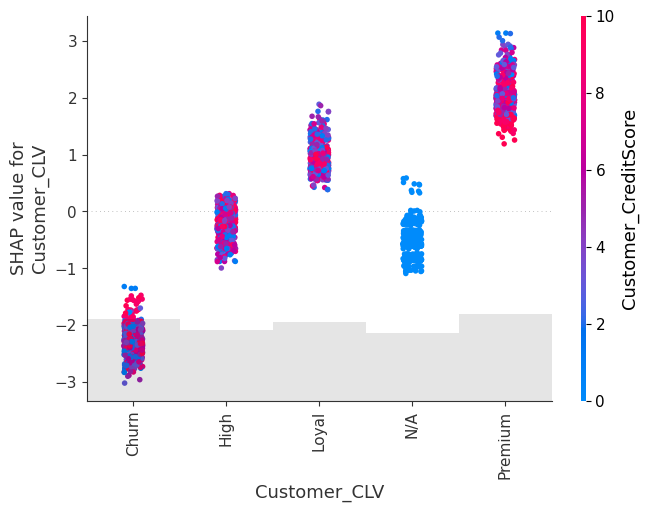

In [45]:
feature = 'Customer_CLV'
shap.plots.scatter(shap_values_exp[:, feature], color=shap_values_exp[:, "Customer_CreditScore"])

### Using global feature importance orderings

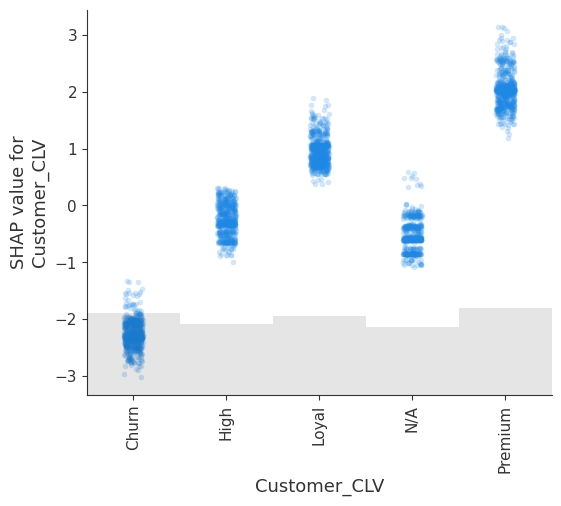

In [46]:
shap.plots.scatter(shap_values_exp[:, shap_values_exp.abs.mean(0).argsort[-1]], alpha=0.2)

## Model Calibration Quality

In [47]:
import numpy as np

# Calibration curves
def calibration(groundtruth, probs):
    # Convert groundtruth to binary and ensure probabilities are in a DataFrame
    groundtruth_binary = 1*np.array(groundtruth)
    nlabels = len(np.unique(groundtruth))
    
    if nlabels < 2:
        return pl.DataFrame({
            "MeanProbs": [0.5],
            "PositivesShare": [None],
            "binPos": [None],
            "binNeg": [None]
        })

    if nlabels > 2:
        raise ValueError("'groundtruth' has more than two levels.")
    
    # Create probabilities DataFrame with binning
    probabilities = pl.DataFrame({
        "groundtruth": groundtruth_binary,
        "probs": probs
    })

    # Group and summarize probabilities
    grouped_probabilities = (probabilities
                             .with_columns((pl.col("probs") * 10).round().alias("bin"))  # Binning probs to 1 decimal place
                             .group_by("bin")
                             .agg([
                                 pl.mean("probs").alias("MeanProbs"),
                                 pl.sum("groundtruth").alias("binPos"),
                                 (pl.count("groundtruth") - pl.sum("groundtruth")).alias("binNeg"),
                                 (pl.sum("groundtruth") / pl.count("groundtruth")).alias("PositivesShare")
                             ])
                             .sort("bin"))
    return grouped_probabilities

In [48]:
y_test_bin = y_test.apply(lambda x: x == 'Clicked')
preds_proba = cbc_1.predict_proba(X_test)
calibration_data = calibration(y_test_bin, preds_proba[:,1])

In [49]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(calibration_data.to_pandas(), 
              x="MeanProbs", 
              y="PositivesShare")


# Add ideal calibration line (diagonal)
fig.add_shape(type="line", line=dict(dash='dash', color="darkred"), row='all', col='all', x0=0, y0=0, x1=1, y1=1)

# Customize the layout and labels
fig.update_layout(
    title="Model calibration plot",
    xaxis_title="Mean predicted probability",
    yaxis_title="Fraction of positives"
)

fig.show()